In [1]:
import pandas as pd
import numpy as np
import os
# import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text as tx
from scipy import sparse
from nltk.corpus import words as nltk_words
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from langdetect import detect
import enchant
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score as auc, average_precision_score as ap
from nltk import word_tokenize

# Installed Libraries by Sammie
from sklearn.linear_model import SGDClassifier
from sklearn. calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sn
import time
import warnings
warnings.filterwarnings('ignore')


In [2]:
plt.style.use('seaborn-darkgrid')
%matplotlib inline

# Use Enchant English Dictionary
d = enchant.Dict("en_US")

In [3]:
df_trn = pd.read_csv(os.path.join('/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master', 'train.csv'), parse_dates=['date'], index_col=['ex_id'])

In [4]:
df_val = pd.read_csv(os.path.join('/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master', 'dev.csv'), parse_dates=['date'], index_col=['ex_id'])

In [5]:
print("***********************************************************************************")
print("Training data has {} rows and {} columns".format(df_trn.shape[0], df_trn.shape[1]))
print("Validation data has {} rows and {} columns".format(df_val.shape[0], df_val.shape[1]))
print("***********************************************************************************")

***********************************************************************************
Training data has 250874 rows and 6 columns
Validation data has 35918 rows and 6 columns
***********************************************************************************


### Baseline 1: Review Data Only

In [6]:
y_trn = df_trn['label']
y_val = df_val['label']

In [7]:
df_eval = pd.DataFrame(columns=['model','trans', 'preproc', 'set', 'auc', 'ap'])

In [8]:
df_eval = pd.DataFrame(columns=['model','trans', 'preproc', 'set', 'auc', 'ap'])

def evaluation_metrix(train_y, pred_train_y, val_y, pred_val_y):
    """ This function calculates AUC and Average Precision on Training and Validation data"""
    auc_trn, auc_val, ap_trn, ap_val = 0.0, 0.0, 0.0, 0.0
    auc_trn = metrics.roc_auc_score(train_y, pred_train_y[:, 1])
    print("AUC value on Train data: {}".format(auc_trn))
    auc_val = metrics.roc_auc_score(val_y, pred_val_y[:, 1])
    print("AUC value on Validation data: {}".format(auc_val))
    ap_trn = metrics.average_precision_score(train_y, pred_train_y[:, 1])
    print("Average Precision on Training data: {}".format(ap_trn))
    ap_val = metrics.average_precision_score(val_y, pred_val_y[:, 1])
    print("Average Precision on Validation data: {}".format(ap_val))
    
    return auc_trn, auc_val, ap_trn, ap_val


def plot_roc_curve(y_validation, yhat_validation):
    """ This function plots the auc-roc curve """
    fpr, tpr, _ = metrics.roc_curve(y_validation,  yhat_validation[::,1])
    auc_ = metrics.roc_auc_score(y_validation, yhat_validation[::,1])
    plt.plot(fpr,tpr,label="data, auc="+str(auc_))
    plt.legend(loc=4)
    plt.show()
    
    
def plot_confusion_matrix(model, validation_train, validation_true):
    """ This plots heatmap of confusion matrix """
    yhat_pred = model.predict(validation_train)
    data = confusion_matrix(validation_true, yhat_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_val), index = np.unique(y_val))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
    
    
# Time taken to run Linear SVM classifier
def combined (X_trn, X_val,y_trn, trans, preproc, df_eval, validation_true_val):
    start = pd.Timestamp.now()
    base_model = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
    model =  CalibratedClassifierCV(base_model).fit(X_trn, y_trn)
    end = pd.Timestamp.now() 
    print("Time taken to run Linear SVM classifier: {} seconds".format((end - start)/pd.Timedelta('1s')))

    # Compute predictions
    yhat_trn = model.predict_proba(X_trn)
    yhat_val = model.predict_proba(X_val)

    # print(auc_trn, auc_val, ap_trn, ap_val)
    auc_trn_cl, auc_val_cl, ap_trn_cl, ap_val_cl = evaluation_metrix(train_y=y_trn, 
                                                                     pred_train_y=yhat_trn, 
                                                                     val_y=validation_true_val, 
                                                                     pred_val_y=yhat_val)
   
    print(auc_trn_cl, auc_val_cl, ap_trn_cl, ap_val_cl)
    # Plot confusion matrix
    
    
    
    # Plot ROC curve
    
    plot_confusion_matrix(model=model, validation_train=X_val, validation_true=validation_true_val)
    fig, ax = plt.subplots(nrows=1)
    plot_roc_curve(y_validation=validation_true_val, yhat_validation=yhat_val)
   

   
    df_eval = df_eval.append({'trans':trans, 
                              'preproc':preproc, 
                              'set':'trn', 
                              'auc':auc_trn_cl, 
                              'ap':ap_trn_cl,
                              'model': 'Linear SVMClassifier'}, ignore_index=True)
    df_eval = df_eval.append({'trans':trans, 
                              'preproc':preproc, 
                              'set':'val',
                              'auc':auc_val_cl,
                              'ap':ap_val_cl,
                              'model': 'Linear SVMClassifier'}, ignore_index=True)
    
    
    
#     print(df_eval)
    
    
    return df_eval

In [9]:
# Train Count Vectorizer
start = pd.Timestamp.now()
count_trans = tx.CountVectorizer(strip_accents='unicode').fit(df_trn['review'])
end = pd.Timestamp.now() 
print("Time Taken to create Count Vectorizer object: {} seconds".format((end - start)/pd.Timedelta('1s')))
X_trn_none = count_trans.transform(df_trn['review'])
X_val_none = count_trans.transform(df_val['review'])


X_trn_count = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/wordcount_train.npz'
X_val_count = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/wordcount_valid.npz'

X_trn_tfidfraw = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfraw_train.npz'
X_val_tfidfraw = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfraw_valid.npz'

X_trn_tfidfrawtrim = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfraw_trim_train.npz'
X_val_tfidfrawtrim = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfraw_trim_valid.npz'

X_trn_tfidfnorm = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfnorm_train.npz'
X_val_tfidfnorm = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfnorm_valid.npz'

X_trn_tfidfnormtrim = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfnorm_trim_train.npz'
X_val_tfidfnormtrim = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfnorm_trim_valid.npz'




Time Taken to create Count Vectorizer object: 70.428178 seconds


Time taken to run Linear SVM classifier: 8.761029 seconds
AUC value on Train data: 0.7530472411842085
AUC value on Validation data: 0.6989661951448578
Average Precision on Training data: 0.2650148070035392
Average Precision on Validation data: 0.18739653813336016
0.7530472411842085 0.6989661951448578 0.2650148070035392 0.18739653813336016


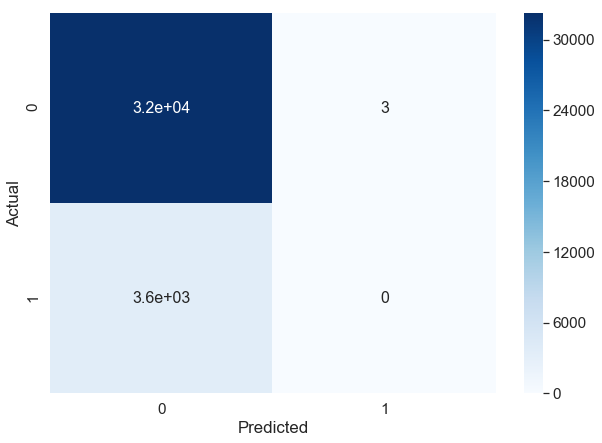

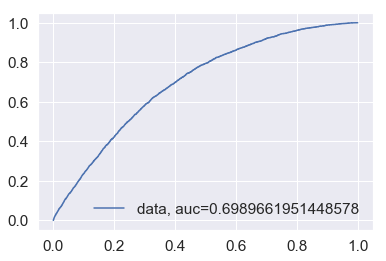

Time taken to run Linear SVM classifier: 8.268547 seconds
AUC value on Train data: 0.752592522001815
AUC value on Validation data: 0.7087873391450427
Average Precision on Training data: 0.2619371379169986
Average Precision on Validation data: 0.19597233619983623
0.752592522001815 0.7087873391450427 0.2619371379169986 0.19597233619983623


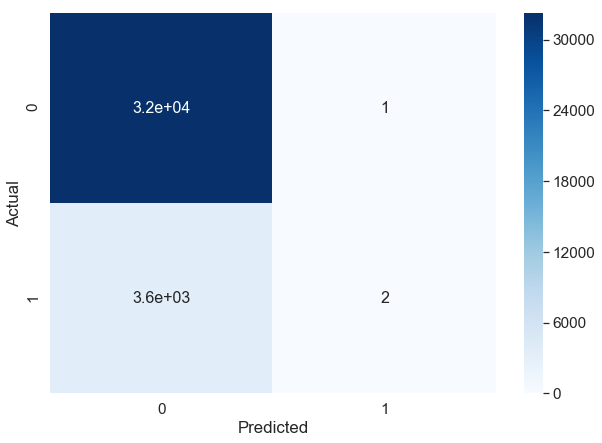

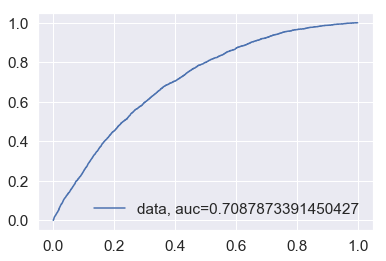

Time taken to run Linear SVM classifier: 12.060443 seconds
AUC value on Train data: 0.8385280950499443
AUC value on Validation data: 0.6920546349605032
Average Precision on Training data: 0.4652426187947547
Average Precision on Validation data: 0.18971278042799544
0.8385280950499443 0.6920546349605032 0.4652426187947547 0.18971278042799544


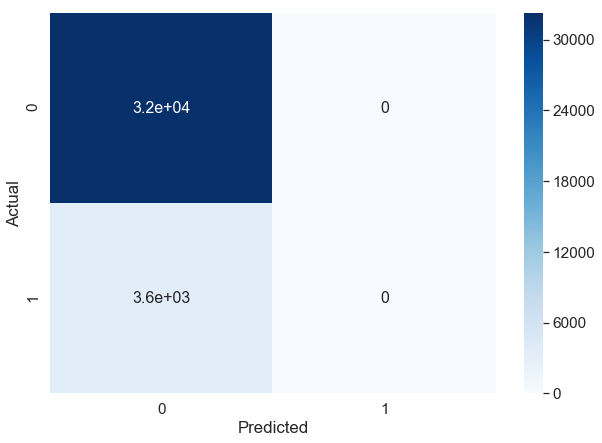

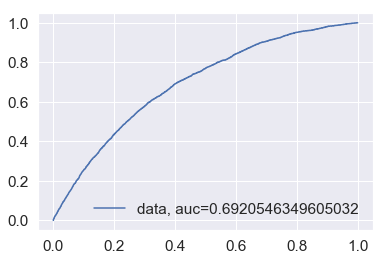

Time taken to run Linear SVM classifier: 7.235034 seconds
AUC value on Train data: 0.82694369172492
AUC value on Validation data: 0.6888410526043961
Average Precision on Training data: 0.4290713378366797
Average Precision on Validation data: 0.18507200924483816
0.82694369172492 0.6888410526043961 0.4290713378366797 0.18507200924483816


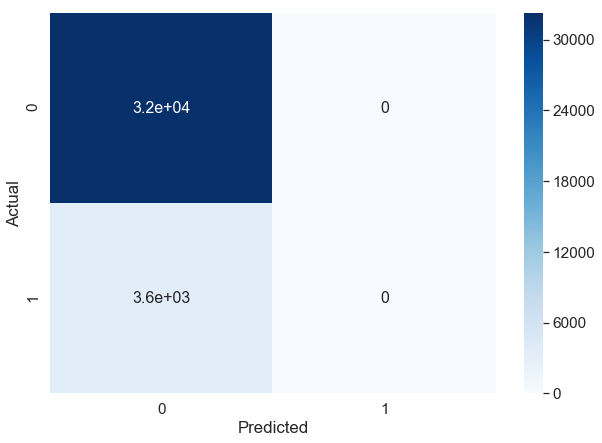

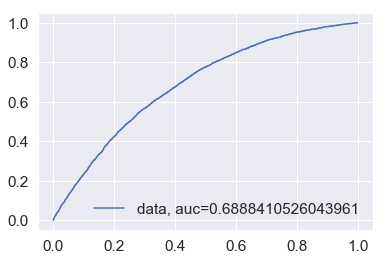

Time taken to run Linear SVM classifier: 10.804286 seconds
AUC value on Train data: 0.8261701022549532
AUC value on Validation data: 0.6742326260336308
Average Precision on Training data: 0.4742510629695206
Average Precision on Validation data: 0.18830318809574378
0.8261701022549532 0.6742326260336308 0.4742510629695206 0.18830318809574378


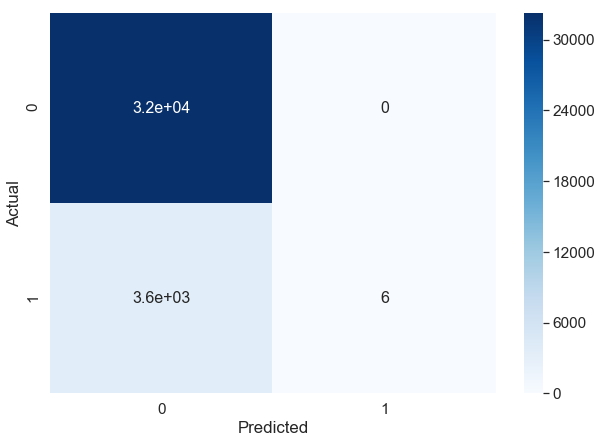

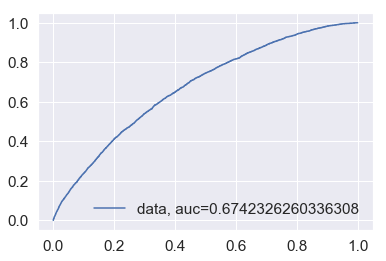

Time taken to run Linear SVM classifier: 7.120552 seconds
AUC value on Train data: 0.8117313158704924
AUC value on Validation data: 0.6752829487629052
Average Precision on Training data: 0.42508400680210245
Average Precision on Validation data: 0.18744611686615864
0.8117313158704924 0.6752829487629052 0.42508400680210245 0.18744611686615864


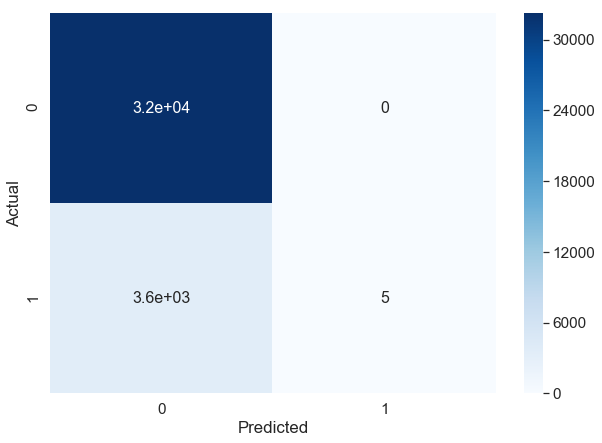

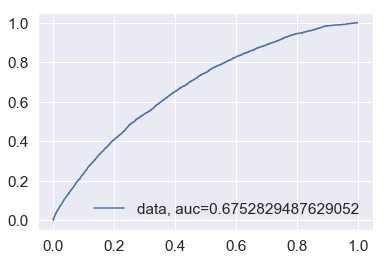

In [10]:
create_paths = [[X_trn_none, X_val_none], [X_trn_count,X_val_count ], [X_trn_tfidfraw, X_val_tfidfraw], [X_trn_tfidfrawtrim, X_val_tfidfrawtrim], 
               [X_trn_tfidfnorm, X_val_tfidfnorm], [X_trn_tfidfnormtrim, X_val_tfidfnormtrim]]

results = pd.DataFrame()
import scipy.sparse as sps
for file_name in create_paths:
    try:

#         below takes care of Count vectorizer with No preprocessing
        if sps.isspmatrix_csr(file_name[0]):
            X_trn=file_name[0]
            X_val=file_name[1]
            preproc = None
            trans = "count"
            results = results.append(combined (X_trn=X_trn, 
                                               X_val=X_val, 
                                               y_trn=y_trn, 
                                               trans=trans, 
                                               preproc=preproc, 
                                               df_eval=df_eval,
                                               validation_true_val=y_val))
    
            
        else:
            # below code takes care of all the other cases
            trans = file_name[0].split("/")[-1].split(".")[0].split('_')

            if len(trans) <= 2:
                trans = trans[0]
            else:
                trans = trans[0] + "_" + trans[1]
            preproc = "lem"
            X_trn=sparse.load_npz(file_name[0])
            X_val = sparse.load_npz(file_name[1])
            results =results.append(combined (X_trn=X_trn, 
                                               X_val=X_val, 
                                               y_trn=y_trn, 
                                               trans=trans, 
                                               preproc=preproc, 
                                               df_eval=df_eval,
                                               validation_true_val=y_val))
     
    except Exception as e:
        print("trace: {}".format(e))
    
   

    

In [11]:
results

,model,trans,preproc,set,auc,ap
0,Linear SVMClassifier,count,None,trn,0.753047,0.265015
1,Linear SVMClassifier,count,None,val,0.698966,0.187397
0,Linear SVMClassifier,wordcount,lem,trn,0.752593,0.261937
1,Linear SVMClassifier,wordcount,lem,val,0.708787,0.195972
0,Linear SVMClassifier,tfidfraw,lem,trn,0.838528,0.465243
1,Linear SVMClassifier,tfidfraw,lem,val,0.692055,0.189713
0,Linear SVMClassifier,tfidfraw_trim,lem,trn,0.826944,0.429071
1,Linear SVMClassifier,tfidfraw_trim,lem,val,0.688841,0.185072
0,Linear SVMClassifier,tfidfnorm,lem,trn,0.826170,0.474251
1,Linear SVMClassifier,tfidfnorm,lem,val,0.674233,0.188303


## Up Samples

In [12]:
df_trn_up = pd.read_csv('/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/df_train_up.csv')
df_trn_up.head()

,ex_id,user_n_reviews,user_avg_rating,user_review_intensity,prod_n_reviews,prod_avg_rating,prod_review_intensity,word_count,pct_en,label
0,15,1,5.0,1.000000,227,3.969163,0.064507,27,92.592593,0
1,16,1,3.0,1.000000,227,3.969163,0.064507,160,99.375000,0
2,18,1,5.0,1.000000,227,3.969163,0.064507,40,100.000000,0
3,19,2,3.5,2.000000,227,3.969163,0.064507,8,100.000000,0
4,21,6,3.5,0.010714,227,3.969163,0.064507,35,100.000000,0


In [13]:
y_trn_up = df_trn_up['label']

In [14]:
y_trn_up.value_counts()

1    225055
0    225055
Name: label, dtype: int64

In [15]:
X_trn_countup = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/wordcount_train_up.npz'
X_val_countup = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/wordcount_valid_up.npz'

X_trn_tfidfrawup = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfraw_train_up.npz'
X_val_tfidfrawup = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfraw_valid_up.npz'

X_trn_tfidfnormup = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfnorm_train_up.npz'
X_val_tfidfnormup = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/tfidfnorm_valid_up.npz'

Time taken to run Linear SVM classifier: 18.407215 seconds
AUC value on Train data: 0.774003251479823
AUC value on Validation data: 0.7243137585694169
Average Precision on Training data: 0.7422815701317211
Average Precision on Validation data: 0.21065557734735357
0.774003251479823 0.7243137585694169 0.7422815701317211 0.21065557734735357


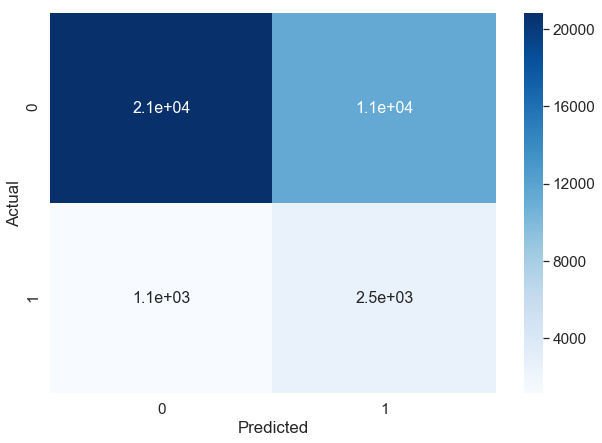

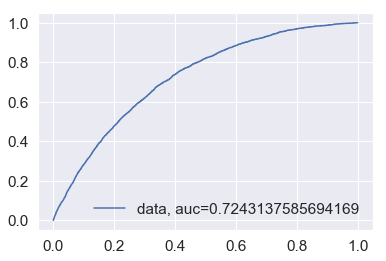

Time taken to run Linear SVM classifier: 18.305082 seconds
AUC value on Train data: 0.774003251479823
AUC value on Validation data: 0.7243137585694169
Average Precision on Training data: 0.7422815701317211
Average Precision on Validation data: 0.21065557734735357
0.774003251479823 0.7243137585694169 0.7422815701317211 0.21065557734735357


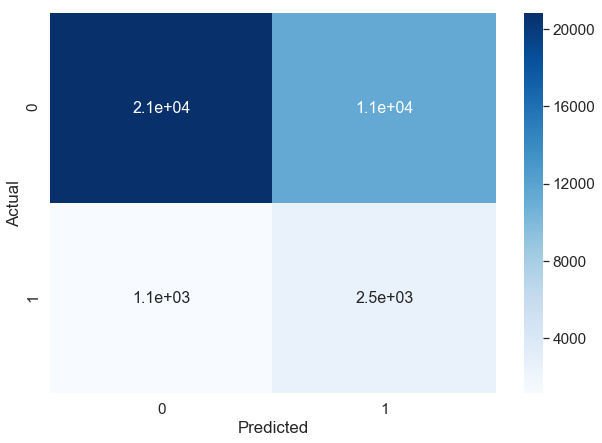

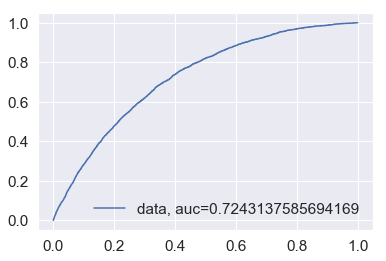

Time taken to run Linear SVM classifier: 15.989043 seconds
AUC value on Train data: 0.717682734959397
AUC value on Validation data: 0.7049744242656533
Average Precision on Training data: 0.6947148108467949
Average Precision on Validation data: 0.20333982377315302
0.717682734959397 0.7049744242656533 0.6947148108467949 0.20333982377315302


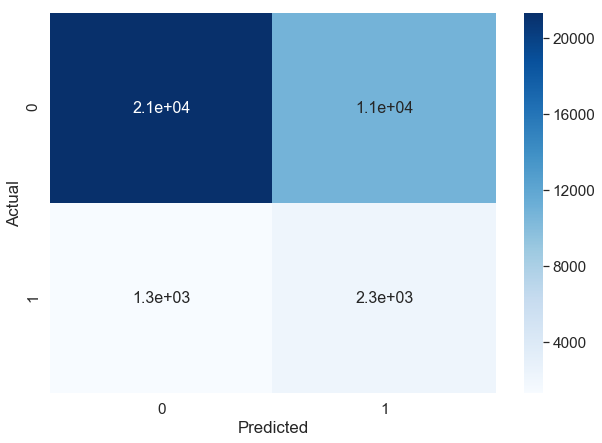

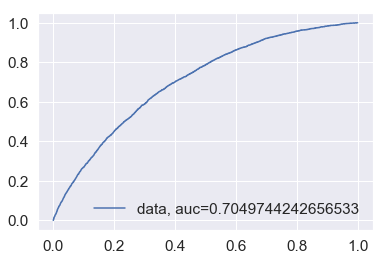

In [16]:
create_paths = [[X_trn_countup,X_val_countup],[X_trn_tfidfrawup, X_val_tfidfrawup], 
                [X_trn_tfidfnormup, X_val_tfidfnormup]]
results_up = pd.DataFrame()
import scipy.sparse as sps
for file_name in create_paths:
    try:

#         below takes care of Count vectorizer with No preprocessing
        if sps.isspmatrix_csr(file_name[0]):
            X_trn=file_name[0]
            X_val=file_name[1]
            preproc = None
            trans = "count"
            results = results.append(combined (X_trn, X_val, y_trn_up,  trans, preproc, df_eval, y_val))
            
        else:
            # below code takes care of all the other cases
            trans = file_name[0].split("/")[-1].split(".")[0].split('_')
            trans = trans[0] + "_" + "up"
            
            # for n-gram code:
#             trans = file_name[0].split("/")[-1].split(".")[0].split('_')
#               trans = trans[0] + "_" +trans[1] + "_" + trans[2]
              
#             
            preproc = "lem"
            X_trn=sparse.load_npz(file_name[0])
            X_val = sparse.load_npz(file_name[1])
            results_up = results_up.append(combined (X_trn, X_val, y_trn_up, trans, preproc, df_eval, y_val))
     
    except Exception as e:
        print("trace: {}".format(e))
    
   

In [17]:
results_up

,model,trans,preproc,set,auc,ap
0,Linear SVMClassifier,wordcount_up,lem,trn,0.774003,0.742282
1,Linear SVMClassifier,wordcount_up,lem,val,0.724314,0.210656
0,Linear SVMClassifier,tfidfraw_up,lem,trn,0.774003,0.742282
1,Linear SVMClassifier,tfidfraw_up,lem,val,0.724314,0.210656
0,Linear SVMClassifier,tfidfnorm_up,lem,trn,0.717683,0.694715
1,Linear SVMClassifier,tfidfnorm_up,lem,val,0.704974,0.203340


In [18]:
# precision = TP/TP+FP

# In training dataset, all your fake samples remians same. So,model learns it pretty well.
results_up.loc[results_up.set=='val']

,model,trans,preproc,set,auc,ap
1,Linear SVMClassifier,wordcount_up,lem,val,0.724314,0.210656
1,Linear SVMClassifier,tfidfraw_up,lem,val,0.724314,0.210656
1,Linear SVMClassifier,tfidfnorm_up,lem,val,0.704974,0.203340


In [19]:
results.loc[results.set=='val']

,model,trans,preproc,set,auc,ap
1,Linear SVMClassifier,count,None,val,0.698966,0.187397
1,Linear SVMClassifier,wordcount,lem,val,0.708787,0.195972
1,Linear SVMClassifier,tfidfraw,lem,val,0.692055,0.189713
1,Linear SVMClassifier,tfidfraw_trim,lem,val,0.688841,0.185072
1,Linear SVMClassifier,tfidfnorm,lem,val,0.674233,0.188303
1,Linear SVMClassifier,tfidfnorm_trim,lem,val,0.675283,0.187446


### ngrams analysis

In [20]:
X_ngram_snow_train = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/ngram_snow_train.npz'
X_ngram_snow_val = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/ngram_snow_valid.npz'

X_ngram_snow_tfidf_train = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/ngram_snow_tfidf_train.npz'
X_ngram_snow_tfidf_val = '/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/ngram_snow_tfidf_valid.npz'


/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/ngram_snow_train.npz
ngram_snow_train
Time taken to run Linear SVM classifier: 71.291424 seconds
AUC value on Train data: 0.9505066275595607
AUC value on Validation data: 0.716925303701227
Average Precision on Training data: 0.7832490944358647
Average Precision on Validation data: 0.21838052643676611
0.9505066275595607 0.716925303701227 0.7832490944358647 0.21838052643676611


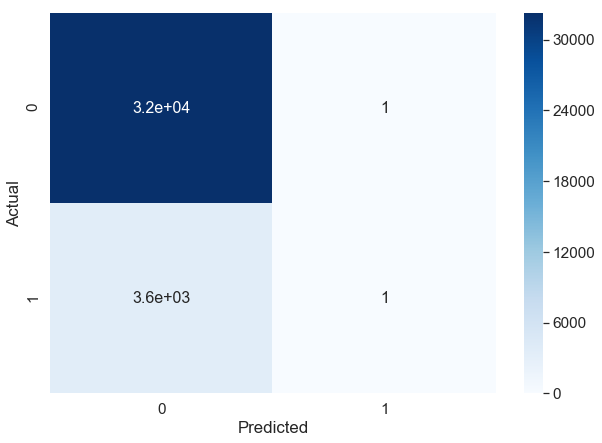

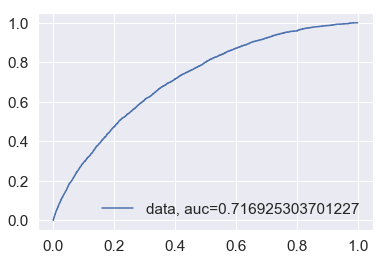

/Users/SammieBKim/Downloads/DS-1003-Part-Time-Bandits-master/ngram_snow_tfidf_train.npz
ngram_snow_tfidf
Time taken to run Linear SVM classifier: 86.163014 seconds
AUC value on Train data: 0.9978121278260957
AUC value on Validation data: 0.7123946067038529
Average Precision on Training data: 0.9874246454958946
Average Precision on Validation data: 0.2331917365584878
0.9978121278260957 0.7123946067038529 0.9874246454958946 0.2331917365584878


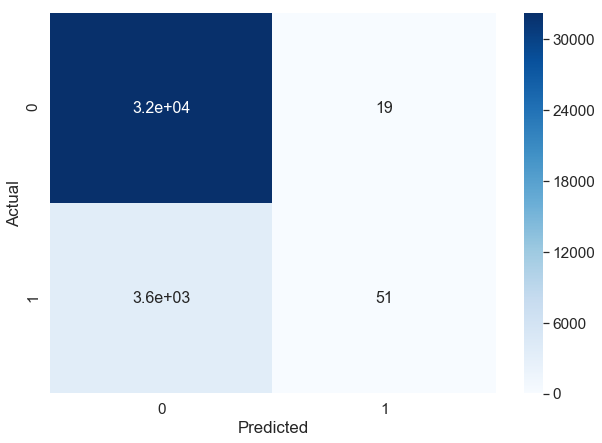

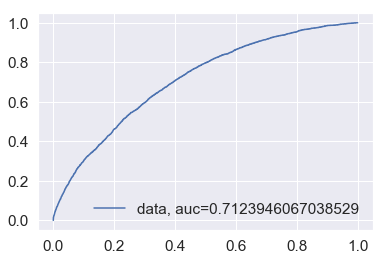

In [21]:
create_paths = [[X_ngram_snow_train, X_ngram_snow_val], [X_ngram_snow_tfidf_train, X_ngram_snow_tfidf_val]]

results_ngram = pd.DataFrame()
import scipy.sparse as sps
for file_name in create_paths:
    try:

        # below code takes care of all the other cases n-gram code:
        trans = file_name[0].split("/")[-1].split(".")[0].split('_')
        print(file_name[0])
        trans = trans[0] + "_" + trans[1] + "_" + trans[2]
        print(trans)
    
        preproc = "snow_stem"
        X_trn=sparse.load_npz(file_name[0])
        X_val = sparse.load_npz(file_name[1])
        results_ngram = results_ngram.append(combined (X_trn, X_val, y_trn, trans, preproc, df_eval, y_val))
     
    except Exception as e:
        print("trace: {}".format(e))
    
   

In [22]:
results_ngram

,model,trans,preproc,set,auc,ap
0,Linear SVMClassifier,ngram_snow_train,snow_stem,trn,0.950507,0.783249
1,Linear SVMClassifier,ngram_snow_train,snow_stem,val,0.716925,0.218381
0,Linear SVMClassifier,ngram_snow_tfidf,snow_stem,trn,0.997812,0.987425
1,Linear SVMClassifier,ngram_snow_tfidf,snow_stem,val,0.712395,0.233192


In [23]:
results_ngram.loc[results_ngram.set=='val']

,model,trans,preproc,set,auc,ap
1,Linear SVMClassifier,ngram_snow_train,snow_stem,val,0.716925,0.218381
1,Linear SVMClassifier,ngram_snow_tfidf,snow_stem,val,0.712395,0.233192


In [24]:
results.loc[results.set=='val']

,model,trans,preproc,set,auc,ap
1,Linear SVMClassifier,count,None,val,0.698966,0.187397
1,Linear SVMClassifier,wordcount,lem,val,0.708787,0.195972
1,Linear SVMClassifier,tfidfraw,lem,val,0.692055,0.189713
1,Linear SVMClassifier,tfidfraw_trim,lem,val,0.688841,0.185072
1,Linear SVMClassifier,tfidfnorm,lem,val,0.674233,0.188303
1,Linear SVMClassifier,tfidfnorm_trim,lem,val,0.675283,0.187446


In [25]:
results_up.loc[results_up.set=='val']

,model,trans,preproc,set,auc,ap
1,Linear SVMClassifier,wordcount_up,lem,val,0.724314,0.210656
1,Linear SVMClassifier,tfidfraw_up,lem,val,0.724314,0.210656
1,Linear SVMClassifier,tfidfnorm_up,lem,val,0.704974,0.203340


#### Snippet to plot word cloud for reviews

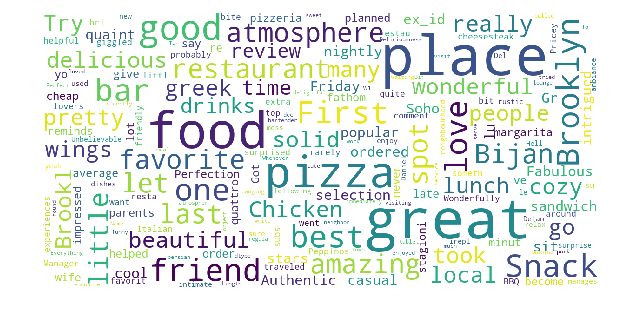

In [26]:
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
# from nltk.corpus import stopwords
stopwords = set(STOPWORDS)

def show_wordcloud(dataframe, title = None):
    wc = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(dataframe))
    
    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wc)
    plt.show()
    
show_wordcloud(df_trn["review"].loc[df_trn['label']==1])